<br>Avenger Face Recognition</font>

<font size="5">Import libraries</font>

In [31]:
import numpy as np
import cv2
import os
import random
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report , accuracy_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

<font size="5">Import dataset</font>

<font size="4">https://www.kaggle.com/rawatjitesh/avengers-face-recognition</font>

In [32]:
image_list = []
image_class_list = []

root_path = './cropped_images'

image_class = 0

for class_name in os.listdir(root_path):
    folder_path = os.path.join(root_path, class_name)
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        print(image_path)
        img = cv2.imread(image_path)
        image_list.append(img)
        image_class_list.append(image_class)
    image_class += 1

./cropped_images\chris_evans\chris_evans1.png
./cropped_images\chris_evans\chris_evans10.png
./cropped_images\chris_evans\chris_evans11.png
./cropped_images\chris_evans\chris_evans12.png
./cropped_images\chris_evans\chris_evans13.png
./cropped_images\chris_evans\chris_evans14.png
./cropped_images\chris_evans\chris_evans15.png
./cropped_images\chris_evans\chris_evans16.png
./cropped_images\chris_evans\chris_evans17.png
./cropped_images\chris_evans\chris_evans18.png
./cropped_images\chris_evans\chris_evans19.png
./cropped_images\chris_evans\chris_evans2.png
./cropped_images\chris_evans\chris_evans20.png
./cropped_images\chris_evans\chris_evans21.png
./cropped_images\chris_evans\chris_evans22.png
./cropped_images\chris_evans\chris_evans23.png
./cropped_images\chris_evans\chris_evans24.png
./cropped_images\chris_evans\chris_evans25.png
./cropped_images\chris_evans\chris_evans26.png
./cropped_images\chris_evans\chris_evans27.png
./cropped_images\chris_evans\chris_evans28.png
./cropped_image

<font size="5">Show several image samples</font>

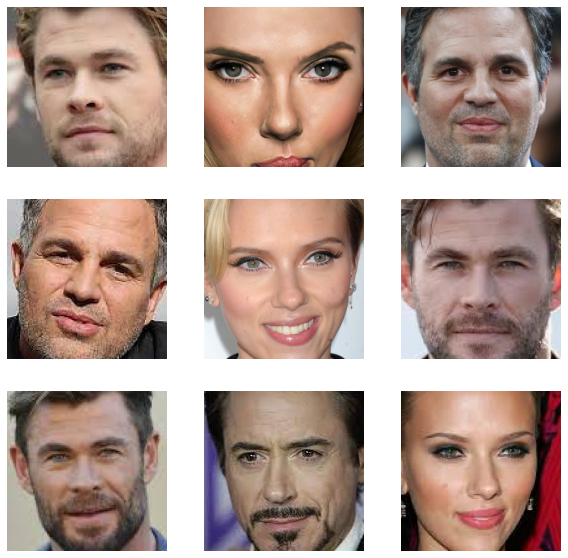

In [33]:
plt.figure(figsize=(10, 10))

img_sample = random.sample(image_list, 9)

for index, img in enumerate(img_sample):
    plt.subplot(3, 3, index + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.show()


<font size="5">Check whether all images are square</font>

In [34]:
non_square_img = 0
square_img = 0

for img in image_list:
    height, width, channels = img.shape
    if height != width:
        non_square_img += 1
    else:
        square_img += 1

print(f"Square Images: {square_img} images")
print(f"Non Square Images: {non_square_img} images")

Square Images: 274 images
Non Square Images: 0 images


<font size="5">Find minimum Image size</font>

In [35]:
min_size = 10000000
channel = 0

for img in image_list:
    height, width, channels = img.shape
    if height < min_size:
        min_size = height
        channel = channels

print(f"Minimum Image Size: {min_size} x {min_size} x {channel}")

Minimum Image Size: 58 x 58 x 3


<font size="5">Resize all images to the minimum image size</font>

In [36]:
resized_image_list = []

for img in image_list:
    resized_image_list.append(cv2.resize(img, (min_size, min_size)))

<font size="5">Convert list to numpy array</font>

In [37]:
resized_image_list = np.array(resized_image_list)
image_class_list = np.array(image_class_list)

print(f"Resized Image List Shape: {resized_image_list.shape}")
print(f"Image Class List Shape: {image_class_list.shape}")

Resized Image List Shape: (274, 58, 58, 3)
Image Class List Shape: (274,)


<font size="5">Convert image to grayscale</font>

In [38]:
grayscale_resized_image_list = []

for img in resized_image_list:
    grayscale_resized_image_list.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

grayscale_resized_image_list = np.array(grayscale_resized_image_list)
print(f"Grayscale Resized Image List Shape: {grayscale_resized_image_list.shape}")

Grayscale Resized Image List Shape: (274, 58, 58)


<font size="5">Duplicate data for PCA purpose (The number of image is less than the feature size)</font>

In [39]:
image_list_for_pca = np.array(grayscale_resized_image_list.reshape(len(grayscale_resized_image_list), -1))

while image_list_for_pca.shape[0] < image_list_for_pca.shape[1]:
    image_list_for_pca = np.concatenate((image_list_for_pca, grayscale_resized_image_list.reshape(len(grayscale_resized_image_list), -1)), axis=0)

print(f"Image list for pca size: {image_list_for_pca.shape}")

Image list for pca size: (3562, 3364)


<font size="5">PCA & analyze the dimension needed</font>

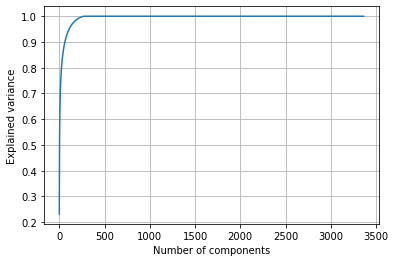

In [40]:
pca = PCA()

pca.fit(image_list_for_pca)

plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

<font size="5">Change the image size to 20 x 20</font>

In [41]:
pca_400 = PCA(n_components=400)

transformed_image_list = pca_400.fit_transform(image_list_for_pca)

print(f"Transformed Image List Shape: {transformed_image_list.shape}")

Transformed Image List Shape: (3562, 400)


<font size="5">Take the original data from the duplicated list</font>

In [42]:
preprocessed_image_list = transformed_image_list[:len(image_class_list)]
preprocessed_image_list = preprocessed_image_list.reshape(-1, 20, 20)

print(f"Preprocessed Image List Shape: {preprocessed_image_list.shape}")

Preprocessed Image List Shape: (274, 20, 20)


<font size="5">Check the preprocessed image samples</font>

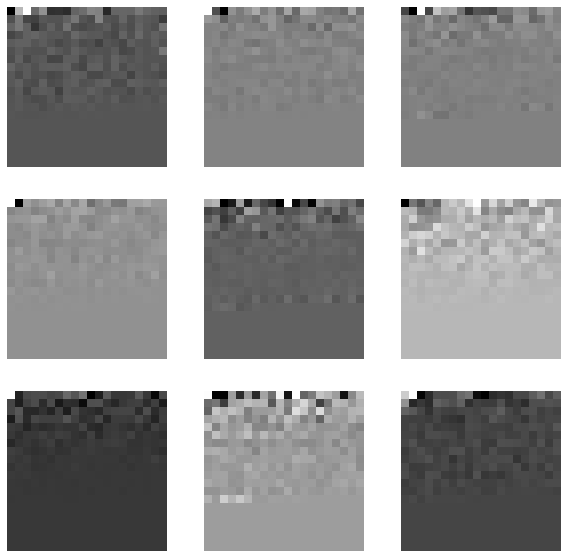

In [43]:
plt.figure(figsize=(10, 10))

idx = np.random.randint(len(preprocessed_image_list), size=9)

for i, index in enumerate(idx):
    plt.subplot(3, 3, i + 1)
    plt.imshow(preprocessed_image_list[index], cmap='gray')
    plt.axis("off")

plt.show()

<font size="5">Train & Test Data Split (80% Train and 20% Test)</font>

In [44]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_image_list, image_class_list, test_size=0.2, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")

print(f"y_train Shape: {y_train.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (219, 20, 20)
X_test Shape: (55, 20, 20)
y_train Shape: (219,)
y_test Shape: (55,)


<font size="5">Create SVC Model & Train</font>

In [45]:
svc = SVC()

svc = svc.fit(X_train.reshape(-1, 400), y_train)

<font size="5">SVC Model Evaluation</font>

Accuracy of SVC Model: 54.54545454545454%

              precision    recall  f1-score   support

           0       0.67      0.36      0.47        11
           1       0.42      0.62      0.50         8
           2       0.53      0.67      0.59        15
           3       0.38      0.38      0.38         8
           4       0.80      0.62      0.70        13

    accuracy                           0.55        55
   macro avg       0.56      0.53      0.53        55
weighted avg       0.58      0.55      0.55        55



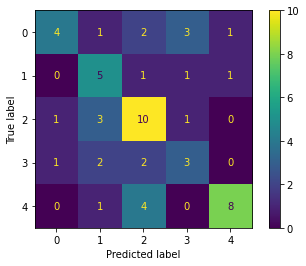

In [46]:
y_svc = svc.predict(X_test.reshape(-1, 400))

print(f"Accuracy of SVC Model: {accuracy_score(y_test, y_svc) * 100}%")
print()
print(classification_report(y_test, y_svc))

cm = confusion_matrix(y_test, y_svc)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

<font size="5">Create KNN Model & Train</font>

In [47]:
knn = KNeighborsClassifier()

knn = knn.fit(X_train.reshape(-1, 400), y_train)

<font size="5">KNN Model Evaluation</font>

Accuracy of KNN Model: 49.09090909090909%

              precision    recall  f1-score   support

           0       0.58      0.64      0.61        11
           1       0.33      0.62      0.43         8
           2       0.60      0.60      0.60        15
           3       0.50      0.25      0.33         8
           4       0.44      0.31      0.36        13

    accuracy                           0.49        55
   macro avg       0.49      0.48      0.47        55
weighted avg       0.51      0.49      0.48        55



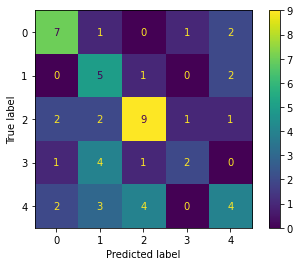

In [48]:
y_knn = knn.predict(X_test.reshape(-1, 400))

print(f"Accuracy of KNN Model: {accuracy_score(y_test, y_knn) * 100}%")
print()
print(classification_report(y_test, y_knn))

cm = confusion_matrix(y_test, y_knn)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

<font size="5">SVC Model has slightly better accuracy than the KNN Model.</font>